In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import yfinance as yf


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## **Cointegrated time series:**

Two time series are said to be **cointegrated** if they have a long-term, statistical relationship such that the difference between their prices or returns is stationary, even if the individual price series are non-stationary. In simpler terms, even though the prices of the two stocks may wander away from one another, they will eventually revert back to their average difference over the long term.

### **Mathematical Representation**

Let's say we have two non-stationary stock price series, $P_t^A$ and $P_t^B$, representing the prices of Stock A and Stock B at time $t$ respectively. If these two series are cointegrated, there exists a vector $(\alpha, \beta)$ such that the linear combination:

$$ Z_t = \alpha P_t^A + \beta P_t^B $$

is stationary. Here, $\alpha$ and $\beta$ are coefficients that define a linear relationship between the two price series, and $Z_t$ represents the spread between them. A stationary time series is one whose properties (mean, variance, etc.) do not depend on time.


#### **EWA and EWC: A Case Study**

In this analysis, we explore the relationship between two Exchange-Traded Funds (ETFs): 

- **EWA (iShares MSCI Australia ETF):** An ETF that seeks to track the investment results of an index composed of Australian equities.
- **EWC (iShares MSCI Canada ETF):** An ETF that aims to track the investment results of an index composed of Canadian equities.

Both Australia and Canada have economies that are significantly influenced by commodity prices due to their rich natural resources. Therefore, it is plausible to hypothesize that the stock market performance of these two countries might be correlated through global commodity prices, and thus, their respective ETFs (EWA and EWC) might be cointegrated.

The primary goal of this analysis is to:
1. **Verify Non-Stationarity:** Ensure that the individual price series (EWA and EWC) are non-stationary.
2. **Identify Cointegration:** Determine whether a stationary relationship exists between them through regression residuals.

By establishing that the residuals from a regression between EWA and EWC are stationary, we can infer a cointegrating relationship between the two ETFs. This relationship can be utilized to develop pairs trading strategies, where the divergence in the price relationship can be exploited for potential profits, assuming that the prices will converge again in the future.

In [2]:
# Define the tickers
tickers = ["EWA", "EWC"]

# Get the data
data = yf.download(tickers, start="2004-01-01", end="2023-10-06")

[*********************100%%**********************]  2 of 2 completed


In [3]:
data = data['Adj Close']
data['Date'] = data.index
data = data.reset_index(drop=True)
data = data[['Date', 'EWA', 'EWC']]
data.head()

,Date,EWA,EWC
0,2004-01-02,5.626266,10.082145
1,2004-01-05,5.684872,10.130716
2,2004-01-06,5.726735,10.109900
3,2004-01-07,5.663942,10.116840
4,2004-01-08,5.747666,10.158473


parameters: 3.0971090, 1.3297329


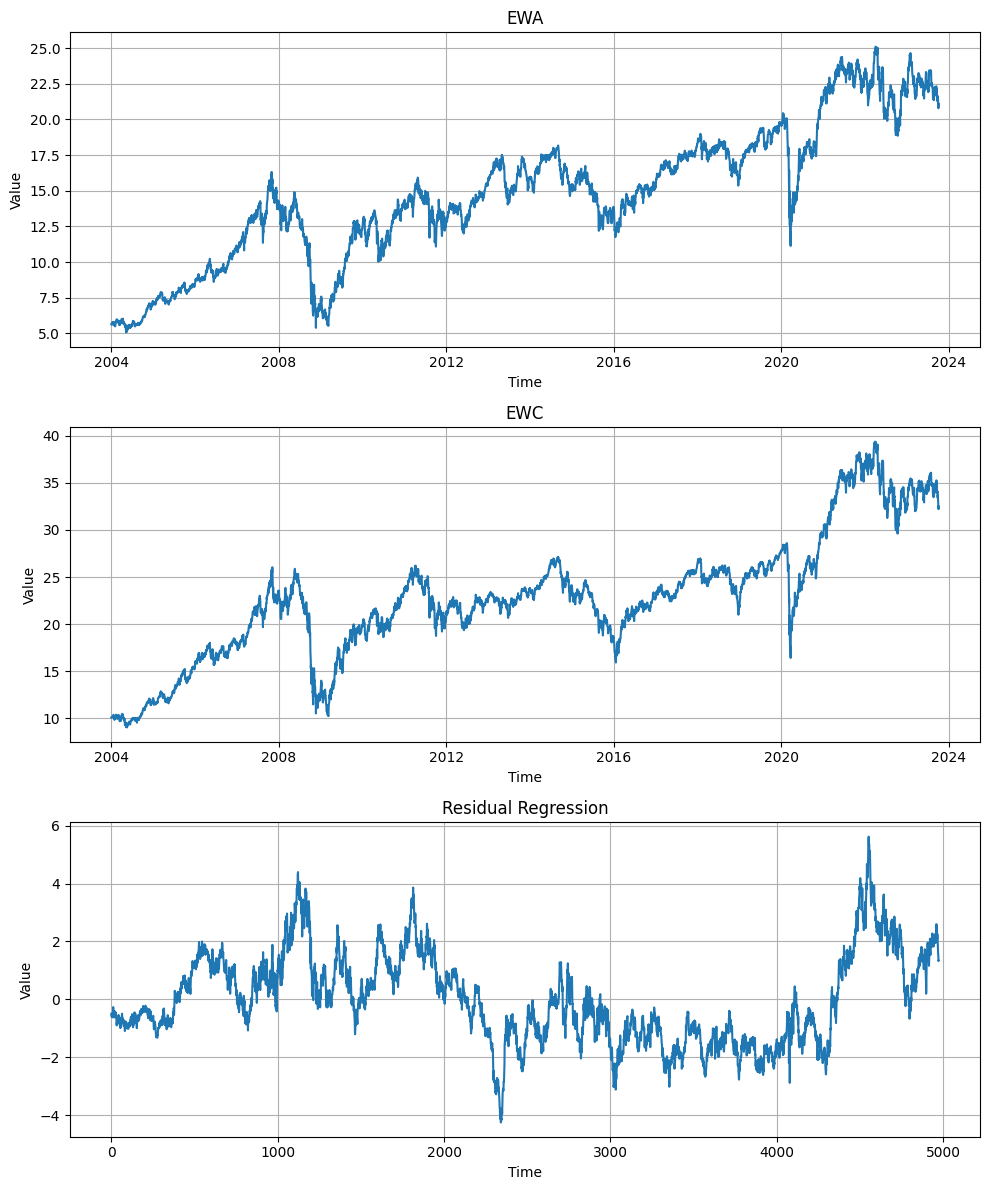

In [4]:
lm_model = LinearRegression(copy_X=True, fit_intercept=True)
lm_model.fit(data['EWA'].values.reshape(-1,1), data['EWC'].values)        # fit() expects 2D array
print('parameters: %.7f, %.7f' %(lm_model.intercept_, lm_model.coef_))

yfit = lm_model.coef_ * data['EWA'] + lm_model.intercept_
y_residual = data['EWC'] - yfit
# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Plot X, Y, and Z
axs[0].plot(data['Date'], data['EWA'].values)
axs[1].plot(data['Date'], data['EWC'].values)
axs[2].plot(y_residual)

# Titles and labels
axs[0].set_title('EWA')
axs[1].set_title('EWC')
axs[2].set_title('Residual Regression')

for ax in axs:
    # ax.legend()
    ax.grid(True)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

# Adjust layout
plt.tight_layout()
plt.show()


In [5]:
# Function to perform ADF test
def perform_adf_test(series, name):
    result = adfuller(series)
    print(f"ADF Statistic for {name}: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    if result[1] <= 0.05:
        print(f"The series {name} is stationary\n")
    else:
        print(f"The series {name} is non-stationary\n")

# Perform ADF test on X, Y, and Z
perform_adf_test(data['EWA'].values, '"EWA"')
print("=============================================================================")
perform_adf_test(data['EWC'].values, '"EWC"')
print("=============================================================================")
perform_adf_test(y_residual, '"Residual Regression"')

ADF Statistic for "EWA": -1.7777943966515304
p-value: 0.391540544989067
Critical Values:
	1%: -3.431672825940294
	5%: -2.8621245446182884
	10%: -2.567081154050482
The series "EWA" is non-stationary

ADF Statistic for "EWC": -1.7464963486273906
p-value: 0.4073292572350787
Critical Values:
	1%: -3.431672825940294
	5%: -2.8621245446182884
	10%: -2.567081154050482
The series "EWC" is non-stationary

ADF Statistic for "Residual Regression": -3.3437848485393813
p-value: 0.013031191000688508
Critical Values:
	1%: -3.4316698889560326
	5%: -2.8621232470799196
	10%: -2.5670804633192237
The series "Residual Regression" is stationary



# **Pairs Trading Strategy with Bollinger Bands: EWA and EWC**

**Pairs trading** is a market-neutral trading strategy that matches a long position with a short position in a pair of cointegrated instruments, such as two stocks. We will explore and implement a pairs trading strategy using the Bollinger Bands technique on two presumably cointegrated assets: EWA and EWC.

### 1. **Pairs Trading:**
   - **Objective:** Exploit any possible "arbitrage" opportunities between a pair of cointegrated assets.
   - **Approach:** Go long (buy) the undervalued asset and short (sell) the overvalued asset with the expectation that the assets will converge in value.

   
      - **Going Long (Buying) the Undervalued Asset**:

         - **Undervalued Asset:** An asset is considered undervalued if it is priced less than its intrinsic value, often due to temporary issues. In the context of pairs trading, it is the asset that is priced lower than its expected value in relation to its paired asset.
         - **Why Go Long?** The expectation is that the undervalued asset will increase in price and revert back to its mean or expected value, providing a profit.
         
      - **Going Short (Selling) the Overvalued Asset:**

         - **Overvalued Asset:** An asset is considered overvalued if it is priced more than its intrinsic value, often due to market over-optimism. In pairs trading, it is the asset that is priced higher than its expected value in relation to its paired asset.
         - **Why Go Short?** The expectation is that the overvalued asset will decrease in price and revert back to its mean or expected value, providing a profit.
         
      - **Profitable Exit:** The strategy aims to exit the positions when the prices of the two assets converge again. This means buying back the asset that was sold short (at a hopefully lower price) and selling the asset that was bought (at a hopefully higher price), securing a profit from the trades.

### **2. Components of Bollinger Bands**

**Middle Band:** The middle band is the moving average (MA) of the asset's price, serving as a baseline for identifying price deviations. Mathematically, it's expressed as:
$$ \text{Middle Band} = \text{MA}(P, N) $$
where $ \text{MA}(P, N) $ is the moving average of price $ P $ over $ N $ periods.

**Upper Band:** The upper band is calculated by adding a multiplier ($ k $) of standard deviations (SD) to the MA, identifying a level that may indicate overbought conditions. Mathematically:
$$ \text{Upper Band} = \text{MA}(P, N) + (k \times \text{SD}(P, N)) $$
where $ k $ is commonly set to 2, and $ \text{SD}(P, N) $ is the standard deviation of price $ P $ over $ N $ periods.

**Lower Band:** The lower band is found by subtracting $ k \times \text{SD}(P, N) $ from the MA, serving to identify potential oversold conditions. Mathematically:
$$ \text{Lower Band} = \text{MA}(P, N) - (k \times \text{SD}(P, N)) $$
with $ k $ and $ \text{SD}(P, N) $ defined as above.


### **3. Purpose of Bollinger Bands**

Bollinger Bands serve to **identify overbought and oversold conditions** in a market:
- **Overbought:** When the price nears the upper band, it might be overvalued, potentially signaling a future decrease.
- **Oversold:** When the price nears the lower band, it might be undervalued, potentially signaling a future increase.

They also **assess volatility** in the market:
- **Expanding Bands:** Suggest increased volatility and potential for upcoming price fluctuations.
- **Contracting Bands:** Suggest decreased volatility and a potential reduction in price fluctuations.


### **4. Strategy Outline**

**1. Calculating Bollinger Bands:** The Bollinger Bands are calculated using a moving average (MA) and standard deviation (SD) of the spread between EWA and EWC. The upper band is defined as `MA + (k * SD)` and the lower band as `MA - (k * SD)`, where `k` is a user-defined constant. These bands aim to identify overbought and oversold conditions in the spread.

**2. Trading Signals:** Trading signals are generated based on the spread's interaction with the Bollinger Bands. Specifically:
- **Short the Spread:** Initiated when the spread touches the upper band, indicating overbought conditions. This involves selling EWA and buying EWC, expecting the spread to revert to the mean (MA).
- **Long the Spread:** Initiated when the spread touches the lower band, indicating oversold conditions. This involves buying EWA and selling EWC, expecting the spread to revert to the mean.
- **Exit Position:** Positions are exited (i.e., trades are closed) when the spread crosses the MA, capturing the profit from the mean reversion.

**3. Avoiding Look-Ahead Bias:** To ensure the model does not use future information in current calculations, a rolling window approach is employed. This involves recalculating model parameters at regular intervals using a fixed-size subset of historical data, ensuring adaptability to new data and avoiding look-ahead bias. Walk forward analysis is used to validate the strategy by using a rolling window for model training and testing the model on subsequent data points.

**4. Spread Types:** The spread between EWA and EWC can be calculated in two ways:
- **Price Spread:** Calculated as the difference in prices between EWA and EWC.
- **Return Spread:** Calculated based on the relative price changes (returns) of EWA and EWC. Note that the exact method for calculating and trading the return spread may depend on additional factors, such as the investment size in each asset.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Sharpe Ratio: 0.26374206430212854
Max Drawdown: 1.0910671506116905


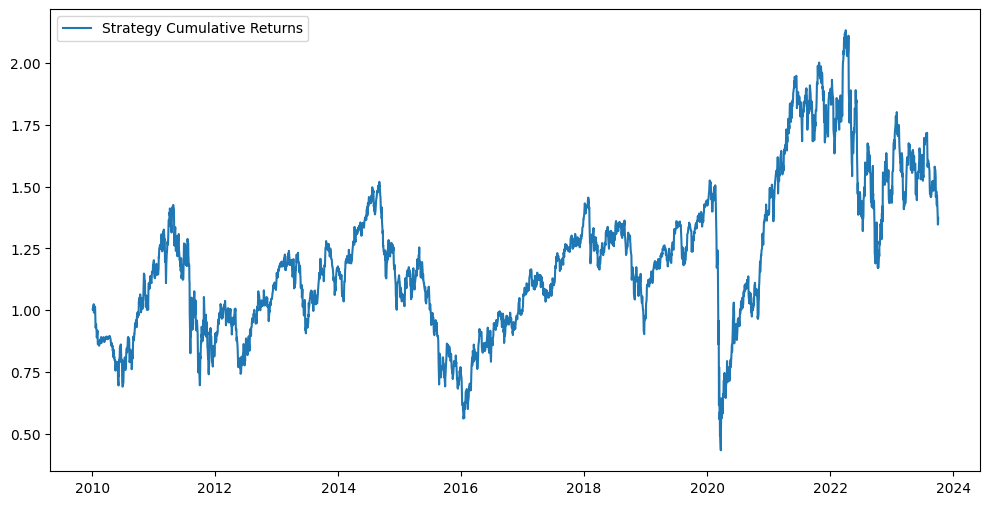

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm

# Data Acquisition
ewa = yf.download('EWA', start='2010-01-01', end='2023-10-06')
ewc = yf.download('EWC', start='2010-01-01', end='2023-10-06')

# Preprocessing: Using Adjusted Close Prices
prices = pd.DataFrame({
    'EWA': ewa['Adj Close'],
    'EWC': ewc['Adj Close']
}).dropna()

# Additional columns for calculations
prices['Spread'] = np.nan
prices['UpperBand'] = np.nan
prices['LowerBand'] = np.nan
prices['MA'] = np.nan  # Moving Average
prices['Position'] = 0  # 1: Long, -1: Short, 0: Flat

# Strategy Development: Calculating Bollinger Bands
window = 20
k = 2

for i in range(window, len(prices)):
    subset = prices.iloc[i-window:i]
    
    # Regression: EWA ~ EWC
    X = sm.add_constant(subset['EWC'])
    y = subset['EWA']
    model = sm.OLS(y, X).fit()
    beta = model.params['EWC']
    
    # Calculate the spread: EWA - beta * EWC
    spread = prices.loc[prices.index[i], 'EWA'] - beta * prices.loc[prices.index[i], 'EWC']
    
    # Bollinger Bands and Moving Average
    upper_band = subset['Spread'].mean() + k * subset['Spread'].std()
    lower_band = subset['Spread'].mean() - k * subset['Spread'].std()
    ma = subset['Spread'].mean()
    
    # Update DataFrame
    prices.loc[prices.index[i], ['Spread', 'UpperBand', 'LowerBand', 'MA']] = spread, upper_band, lower_band, ma
    
    # Generate trading signals 
    if spread > upper_band and prices.loc[prices.index[i-1], 'Position'] <= 0:
        prices.loc[prices.index[i], 'Position'] = -1  # Short signal
    elif spread < lower_band and prices.loc[prices.index[i-1], 'Position'] >= 0:
        prices.loc[prices.index[i], 'Position'] = 1  # Long signal
    elif np.abs(spread - ma) < 0.01 and prices.loc[prices.index[i-1], 'Position'] != 0:
        prices.loc[prices.index[i], 'Position'] = 0  # Exit signal
    else:
        # Maintain previous position
        prices.loc[prices.index[i], 'Position'] = prices.loc[prices.index[i-1], 'Position']

# Backtesting: Calculating Returns and Positions
prices['Return'] = prices['EWA'].pct_change() - prices['Position'].shift(1) * prices['EWC'].pct_change()

# Performance Evaluation
cumulative_return = (prices['Return']+1).cumprod()
sharpe_ratio = prices['Return'].mean() / prices['Return'].std() * np.sqrt(252)
max_drawdown = (cumulative_return.cummax() - cumulative_return).max()

print(f'Sharpe Ratio: {sharpe_ratio}')
print(f'Max Drawdown: {max_drawdown}')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(cumulative_return, label='Strategy Cumulative Returns')
plt.legend()
plt.show()
